# Importing the required libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, AutoModelForSeq2SeqLM
from tqdm import tqdm
from torchvision import models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing import image
from torchmetrics.classification import MultilabelF1Score

### Setting up the environment
***

In [2]:
warnings.filterwarnings("ignore")

***

# Data Preprocessing

In [3]:
with open('ml1m/content/dataset/genres.txt', 'r') as f:
    genre_all = f.readlines()
genres = [genre.strip() for genre in genre_all]

mapping = {}
for genre, i in enumerate(genres):
    mapping[genre] = i

In [4]:
users = pd.read_csv('ml1m/content/dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('ml1m/content/dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('ml1m/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='ISO-8859-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('ml1m/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='ISO-8859-1', index_col=False).set_index('movieid')
movies_train['genre'] = movies_train.genre.str.split('|')
movies_train.index.name = 'ID'
movies_test['genre'] = movies_test.genre.str.split('|')
movies_test.index.name = 'ID'

*** 
Must add overview column to this table via generator

In [5]:
def preprocess(df, path='ml1m/content/dataset/ml1m-images', genres=genres) -> pd.DataFrame:
    df['img_path'] = df.apply(lambda x: os.path.join(path, str(x.name) + '.jpg'), axis=1)
    df['label'] = df.genre.apply(lambda x: [1 if genre in x else 0 for genre in genres])
    df.drop(columns=['genre'], inplace=True)
    df = df.reset_index(drop=True)
    return df

***

In [6]:
trainset = preprocess(movies_train)
testset = preprocess(movies_test)

In [7]:
trainset = pd.read_csv('trainset.csv')
testset = pd.read_csv('testset.csv')
trainset.label = trainset.label.apply(lambda x: eval(x))
testset.label = testset.label.apply(lambda x: eval(x))

In [8]:
print(len(trainset), len(testset))

3106 777


In [9]:
tokenizer_gen = AutoTokenizer.from_pretrained("MBZUAI/LaMini-Flan-T5-248M")
model_gen = AutoModelForSeq2SeqLM.from_pretrained("MBZUAI/LaMini-Flan-T5-248M")

In [10]:
def generate_plot(df: pd.DataFrame, model: AutoModelForSeq2SeqLM, tokenizer: AutoTokenizer, device) -> pd.DataFrame:
    quote = 'What is the story of the movie {}?'
    model_gen.to(device)
    model_gen.eval()

    for i in tqdm(range(len(df))):
        with torch.no_grad():
            input_ids = tokenizer(quote.format(df.title[i]), return_tensors='pt').input_ids.to(device)
            output = model.generate(input_ids, max_length=256, do_sample=True, temperature=0.09)
            df.loc[i, 'plot'] = tokenizer.decode(output[0], skip_special_tokens=True)
    return df

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# trainset = generate_plot(trainset, model_gen, tokenizer_gen, device)
# testset = generate_plot(testset, model_gen, tokenizer_gen, device)

# Model Implementation

### Sub-models
***

In [13]:
tokenizer1 = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model1 = DistilBertForSequenceClassification .from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification", num_labels=18)
model1.config.id2label = mapping

tokenizer2 = AutoTokenizer.from_pretrained("dduy193/plot-classification")
model2 = AutoModelForSequenceClassification.from_pretrained("dduy193/plot-classification")
model2.config.id2label = mapping

model3 = models.resnet101(pretrained=False)
model3.fc = torch.nn.Linear(2048, len(genres))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
model2.to(device)
model3.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Deep Fusion Multimodal Model
***

In [14]:
class Multimodal(torch.nn.Module):
    def __init__(self, model1, model2, model3):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.fc1 = torch.nn.Linear(18, 18)
        self.fc2 = torch.nn.Linear(18, 18)
        self.fc3 = torch.nn.Linear(18, 18)

    def forward(self, 
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input):
        title_output = self.model1(title_input_ids, title_attention_mask)
        plot_output = self.model2(plot_input_ids, plot_attention_mask)
        image_output = self.model3(image_input)

        title_output = self.fc1(title_output.logits)
        plot_output = self.fc2(plot_output.logits)
        image_output = self.fc3(image_output)
        
        output = torch.add(title_output, plot_output)
        output = torch.add(output, image_output)
        return output

# Custom Datasets & Data Loaders

***
### Custom Dataset
***

In [15]:
class Poroset(torch.utils.data.Dataset):
    def __init__(self, df, 
                 tokenizer1, tokenizer2, 
                 max_len1=64, max_len2=256,
                 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        self.df = df
        self.tokenizer1 = tokenizer1
        self.tokenizer2 = tokenizer2
        self.max_len1 = max_len1
        self.max_len2 = max_len2
        self.image = image
        self.device = device
        self.transform = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        title = row['title']
        # Truncate title if it is too long
        if len(title) > self.max_len1:
            title = title[:self.max_len1]

        plot = row['plot']
        # Truncate plot if it is too long
        if len(plot) > self.max_len2:
            plot = plot[:self.max_len2]

        label = row['label']
        title_encoding = self.tokenizer1(title, truncation=True, padding='max_length', max_length=self.max_len1, return_tensors='pt')
        plot_encoding = self.tokenizer2(plot, truncation=True, padding='max_length', max_length=self.max_len2, return_tensors='pt')
        
        path='ml1m/content/dataset/ml1m-images'
        image_path = os.path.join(path, str(row.name) + '.jpg')
        if os.path.exists(image_path):
            image_input = image.load_img(image_path)
            image_input = self.transform(image_input)
        else:
            image_input = torch.zeros((3, 224, 224))
        
        return {
            'title': title,
            'plot': plot,
            'title_input_ids': title_encoding['input_ids'].squeeze(),
            'title_attention_mask': title_encoding['attention_mask'].squeeze(),
            'plot_input_ids': plot_encoding['input_ids'].squeeze(),
            'plot_attention_mask': plot_encoding['attention_mask'].squeeze(),
            'image_input': image_input,
            'label': torch.FloatTensor(label)
        }

In [16]:
trainset = Poroset(df=trainset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                   max_len1=64, max_len2=256,
                   device=device)
testset = Poroset(df=testset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                  max_len1=64, max_len2=256,
                  device=device)


***
### Custom Data Loader
***

In [17]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Check if the data loader is working properly

In [18]:
sample = next(iter(trainloader))

# First sample of the batch
print('Title: ', sample['title'][0])
print('Plot: ', sample['plot'][0])
print('Label: ', sample['label'][0])
print('Image: ', sample['image_input'][0].shape)

Title:  Mr. Magoo (1997)
Plot:  Mr. Magoo is a 1997 animated film about a man named Mr. Magoo who is a sailor and a sailor who is stranded on a deserted island. He is rescued by a group of sailors who are trying to find him and rescue him.
Label:  tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Image:  torch.Size([3, 224, 224])


# Setting up the Trainer

***
### GPU & Model Configuration
***

In [19]:
model = Multimodal(model1, model2, model3)
model.to(device)

# Freeze layers
# for param in model.model2.parameters():
#     param.requires_grad = False

Multimodal(
  (model1): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn

***
### Setting up loss function & optimizer
***

In [20]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [26]:
def apk(actual, predicted, k = 18):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if len(actual) == 0:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k = 18):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

***
### Trainer & Validation
***

In [21]:
history_loss = []
history_f1 = []
history_mapk = []
def train(epoch):
    model.train()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []
    for _, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        title_input_ids = data['title_input_ids'].to(device)
        title_attention_mask = data['title_attention_mask'].to(device)
        plot_input_ids = data['plot_input_ids'].to(device)
        plot_attention_mask = data['plot_attention_mask'].to(device)
        image_input = data['image_input'].to(device)
        label = data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(
            title_input_ids, title_attention_mask,
            plot_input_ids, plot_attention_mask,
            image_input
        )
        
        loss = loss_fn(outputs, label)
        loss.backward()
        optimizer.step()

        predicted.extend(torch.sigmoid(outputs).cpu().numpy())
        actual.extend(label.cpu().numpy())
        f1(torch.sigmoid(outputs), label)
    print(f'Epoch: {epoch}, Train Loss: {loss.item()}, Train F1: {f1.compute().item()}, Train MAP@18: {mapk(actual, predicted)}')
    history_loss.append(loss.item())
    history_f1.append(f1.compute().item())
    history_mapk.append(mapk(actual, predicted))

# Training Loop

In [22]:
for epoch in range(0):
    train(epoch)

In [24]:
# Save model
torch.save(model.state_dict(), 'multimodel.pt')

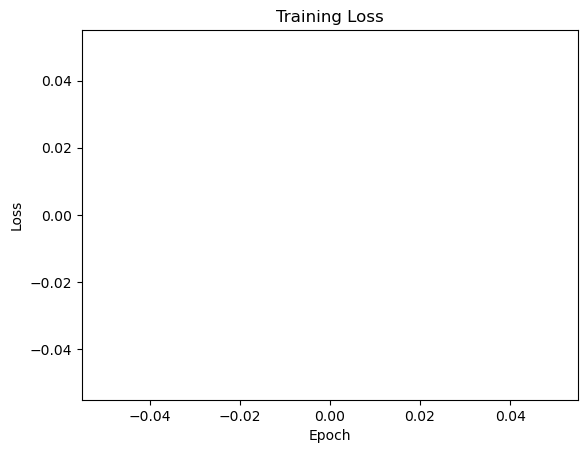

In [25]:
# Visualize training loss
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Testing the model

In [29]:
# Validation
def test(testing_loader):
    model.eval()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)
    
    actual = []
    predicted = []

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0), total=len(testing_loader)):
            title_input_ids = data['title_input_ids'].to(device)
            title_attention_mask = data['title_attention_mask'].to(device)
            plot_input_ids = data['plot_input_ids'].to(device)
            plot_attention_mask = data['plot_attention_mask'].to(device)
            image_input = data['image_input'].to(device)
            label = data['label'].to(device)

            outputs = model(
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input
            )
            predicted.extend(torch.sigmoid(outputs).cpu().numpy())
            actual.extend(label.cpu().numpy())
            f1(torch.sigmoid(outputs), label)
    print(f'F1 Score: {f1.compute()}')
    print(f'MAP@18: {mapk(actual, predicted)}')

In [30]:
test(testloader)

100%|██████████| 25/25 [00:08<00:00,  2.80it/s]


F1 Score: 0.08918388187885284
MAP@18: 0.09152009152009154


In [ ]:
# Inferencing title and overview
def inference(title, overview = None, genres = genres):
    model.eval()
    with torch.no_grad():
        title_encoding = tokenizer(title, truncation=True, padding='max_length', max_length=256, return_tensors='pt')
        title_input_ids = title_encoding['input_ids'].to(device)
        title_attention_mask = title_encoding['attention_mask'].to(device)
        if overview is not None:
            overview_encoding = tokenizer(overview, truncation=True, padding='max_length', max_length=256, return_tensors='pt')
            overview_input_ids = overview_encoding['input_ids'].to(device)
            overview_attention_mask = overview_encoding['attention_mask'].to(device)
            outputs = model(title_input_ids, title_attention_mask, overview_input_ids, overview_attention_mask)
        else:
            outputs = model(title_input_ids, title_attention_mask, None, None)
        outputs = outputs.cpu().detach().numpy().tolist()
        outputs = np.array(outputs) >= 0.5
        print([genres[i] for i in range(len(genres)) if outputs[0][i] == 1])

In [ ]:
print(testset[3]['title'])
#print genres of the movie in testset in word
for i in range(len(genres)):
    if testset[3]['label'][i] == 1:
        print(genres[i])

In [ ]:
inference(testset[3]['title'],testset[3]['overview'])